In [1]:
import sys
from pathlib import Path
from dataclasses import dataclass, field
from typing import Callable
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

ASSET_FOLDER = './assets' # For project exports


project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src import manim_animator, simulation_data

# Drone path simulation

This is a simple blog post on creating a 3-dimensional aerial drone simulation. The simulation contains these parts

- Underlying physics simulation
- Simple goal-based controller with drone thrust
- Simulated lidar scans
- Obstacles in 3-dimensions

After reading this post, we have created something to develop further into a more complete drone simulation.

## Drone

We assume that our drone is well approximated by a point mass. The state of the drone is the current position $p = (x, y, z)$ and velocity $v = (v_x, v_y, v_z)$. Drone also has thrusters which we can approximate as a thrust vector anchored at the current position. The thrust is a force vector $F_T$ which can be aimed in any direction as long as the angle of the thrust direction and the angle of the world Z-axis is less than a limit. We assume that the body frame is formed with taking the thrust vector as the body z-axis, $b_z$, and the orthogonal with largest $x$ component in world frame is the body frame x-axis $b_x$, $b_y = b_z \times b_x$ completes the body frame.

Below is a diagram illustrating the body and world coordinate frames, the diagram is drawn in the $xz$-plane.

<img src="./assets/drone_diag.svg">

We essentially define $b_z$ to **always** point to the direction of thrust $F_T$. Also, let $\phi$ be the angle of world $z$-axis and $b_z$.  

In [2]:
@dataclass
class DroneState:
    position: np.ndarray
    velocity: np.ndarray
    thrust: np.ndarray = field(default_factory=lambda: np.zeros(3))
    timestamp: float = 0

@dataclass
class DroneParams:
    weight: float
    max_thrust: float
    min_thrust: float
    thrust_angle_limit: float
    guidance_accuracy: float
    thrust_accuracy: float
    controller_frequency: float = 10.0

GRAVITY = np.array([0, 0, -9.81])
dt = 1E-2 # The delta step time for physics simulation

In [3]:
current_state = DroneState(
    position=np.array([0, 0, 1.0]),
    velocity=np.zeros(3),
)

drone_params = DroneParams(
    weight=1,
    max_thrust=10,
    min_thrust=1,
    thrust_angle_limit=1 * ((2 * np.pi) / 360), # Conversion from degrees to rad
    guidance_accuracy=0.1,
    thrust_accuracy=0.2
)

In [4]:
def _state_derivatives(state: DroneState, params: DroneParams, F_T: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    computes the derivatives of the state (p_dot, v_dot) arguments 
    state: the current state (p, v) 
    params: the drone parameters
    F_T: the thrust of the drone 
    """

    v_dot = F_T / params.weight + GRAVITY
    p_dot = state.velocity

    return (p_dot, v_dot)

# Runge-Kutta scheme with 4 intermediate points, adapted to our code for computing the state of the drone.
def rk4_step_plant(state: DroneState, dt: float, params: DroneParams, F_cmd: np.ndarray) -> DroneState:
    (k1_p, k1_v) = _state_derivatives(state, params, F_cmd)

    s2 = DroneState(position= state.position + 0.5 * dt * k1_p, velocity = state.velocity + 0.5 * dt * k1_v)
    (k2_p, k2_v) = _state_derivatives(s2, params, F_cmd)

    s3 = DroneState(position = state.position + 0.5 * dt * k2_p, velocity = state.velocity + 0.5 * dt * k2_v)
    (k3_p, k3_v) = _state_derivatives(s3, params, F_cmd)

    s4 = DroneState(position = state.position + 0.5 * dt * k3_p, velocity = state.velocity + 0.5 * dt * k3_v)
    (k4_p, k4_v) = _state_derivatives(s4, params, F_cmd)

    p_new = state.position + (dt/6)*(k1_p + 2*k2_p + 2*k3_p + k4_p)
    v_new = state.velocity + (dt/6)*(k1_v + 2*k2_v + 2*k3_v + k4_v)

    # Checking collision with ground
    if p_new[2] < 0.0:
        p_new = np.asarray([p_new[0], p_new[1], 0.001])

    return DroneState(p_new, v_new)

### Testing the integrator

In [5]:
T_final = 1.0
timerange = np.linspace(0, T_final, num = int(T_final / dt))

states = []

# Beat gravity and accelerate 1.0 m/s^2 in positive z
thrust = -GRAVITY[:] + np.array([0, 0, 1.0])
for i, t in enumerate(timerange):
    new_state = rk4_step_plant(current_state, dt, drone_params, thrust)
    states.append(new_state)
    current_state = new_state

positions = np.asarray([state.position for state in states])

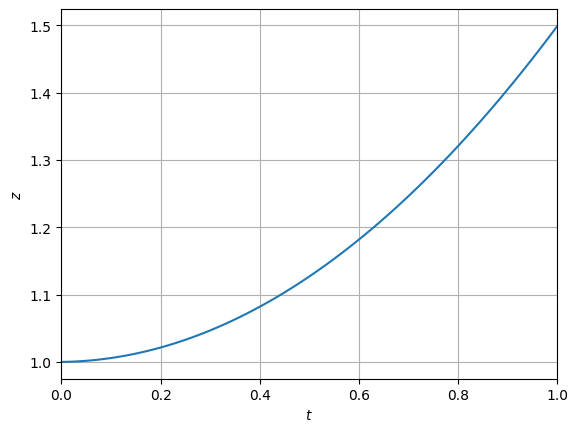

In [6]:
sns.lineplot(y = positions[:, 2], x = timerange).set(xlim=(0, T_final), xlabel='$t$', ylabel='$z$');
plt.grid()

For the case where our thrust is $F_T = -G + (0, 0, 1.0)^T$. We can see that after $1.0$ seconds, we have reached the altitude of $1.5$ meters, since we started from $1.0$ we have gained $0.5$ meters in a second. This corresponds nicely to the equation $x = 1/2 at^2$.

We are therefore happy with our integration scheme. We will use the integrator later when we implement our simulation loop.

## Obstacles & LIDAR

We create artificial obstacles for the drone to evade. For simplicity, we assume that these obstacles are cuboids which extend to infinity in the Z-direction, this makes the obstacles behave like trees or pillars. An obstacle $B$ therefore spans the whole $Z$ axis and is bounded as a rectangle in the xy-plane, $B = [x_1, x_2] \times [y_1, y_2] \times [0, \infty)$.

So sense and ultimately evade these objects, we have a lidar pointed at the direction of horizontal velocity. The horizontal Lidar field-of-view i $\phi_\text{FOV}$ and the angle $\phi_\text{FOV} = 0$ corresponds to the direction of $v$.


In [7]:
@dataclass
class Obstacle:
    x_lim: tuple[float, float]
    y_lim: tuple[float, float]


In [8]:

def raycast_obstacle(pos_xy: np.ndarray, direction: np.ndarray, obs: Obstacle):
    """
    Ray: pos_xy + t * direction, t >= 0
    Returns smallest positive t if ray hits obstacle, else returns None.
    """
    x0, y0 = pos_xy
    dx, dy = direction


    t_candidates = []
    # Vertical edges: x = x_min, x = x_max
    for x_edge in obs.x_lim:
        if abs(dx) > 1e-8:
            t = (x_edge - x0) / dx
            if t >= 0:
                y_hit = y0 + t * dy
                # Check that the y coordinate is within the obstacle limits
                if obs.y_lim[0] <= y_hit <= obs.y_lim[1]:
                    t_candidates.append(t)

    # Horizontal edges: y = y_min, y = y_max
    for y_edge in obs.y_lim:
        if abs(dy) > 1e-8:
            t = (y_edge - y0) / dy
            if t >= 0:
                x_hit = x0 + t * dx
                if obs.x_lim[0] <= x_hit <= obs.x_lim[1]:
                    t_candidates.append(t)

    return min(t_candidates) if len(t_candidates) > 0 else None

def lidar_scan(
    pos_xy: np.ndarray,
    vel_xy: np.ndarray,
    obstacles: list[Obstacle],
    phi_fov: float,
    n_rays: int,
    max_range: float = 50.0,
    noise_std: float = 0.0,
):
    """
    Perform a 2D lidar-style scan in the xy-plane.

    Parameters
    ----------
    pos_xy : (2,) array
        Drone position in xy.
    vel_xy : (2,) array
        Drone horizontal velocity (defines forward direction).
    obstacles : list[Obstacle]
        List of rectangular obstacles.
    phi_fov : float
        Field-of-view in radians (total angle).
    n_rays : int
        Number of rays in the scan.
    max_range : float
        Maximum sensing range. Rays that hit nothing return this.
    noise_std : float
        Standard deviation of Gaussian noise added to distances.

    Returns
    -------
    ray_angles : (n_rays,) array
        Global angles (in radians) of each ray in the world frame.
    ray_dirs : (n_rays, 2) array
        Unit direction vectors for each ray.
    distances : (n_rays,) array
        Measured distance for each ray (<= max_range).
    hit_mask : (n_rays,) bool array
        True if the ray hit an obstacle before max_range.
    """

    pos_xy = np.asarray(pos_xy, dtype=float)
    vel_xy = np.asarray(vel_xy, dtype=float)

    # Handle zero horizontal velocity: default forward is +x
    norm_v = np.linalg.norm(vel_xy)
    if norm_v < 1e-8:
        forward_angle = 0.0
    else:
        forward_angle = np.arctan2(vel_xy[1], vel_xy[0])

    # Angles in world frame, centered around forward direction
    # phi_fov = 0 points along forward direction
    ray_angles = forward_angle + np.linspace(-phi_fov / 2, phi_fov / 2, n_rays)

    ray_dirs = np.stack([np.cos(ray_angles), np.sin(ray_angles)], axis=-1)

    distances = np.full(n_rays, max_range, dtype=float)
    hit_mask = np.zeros(n_rays, dtype=bool)

    for i in range(n_rays):
        direction = ray_dirs[i]
        best_t = None

        for obs in obstacles:
            # Check the closest t value, this corresponds to the minimum distance of the obstacle and drone:
            t = raycast_obstacle(pos_xy, direction, obs)
            if t is not None and 0.0 <= t <= max_range:
                if (best_t is None) or (t < best_t):
                    best_t = t

        if best_t is not None:
            distances[i] = best_t
            hit_mask[i] = True
    return ray_angles, ray_dirs, distances, hit_mask

def obstacle_repulsive_force(
    ray_dirs: np.ndarray,
    distances: np.ndarray,
    hit_mask: np.ndarray,
    d0: float = 10.0,
    k_rep: float = 5.0,
) -> np.ndarray:
    """
    Compute a simple repulsive force from lidar rays.

    - Only rays with distance < d0 contribute.
    - Force magnitude ~ (1/d - 1/d0).

    Returns a 2D force vector in the xy-plane.
    """
    F_rep = np.zeros(2, dtype=float)

    close = hit_mask & (distances < d0)

    if not np.any(close):
        return F_rep

    d = distances[close]
    dirs = ray_dirs[close]

    # Repulsive force points opposite to ray direction
    weights = k_rep * (1.0 / d - 1.0 / d0)
    weights = np.clip(weights, 0.0, None)  # no negative contributions

    # Sum contributions
    for w, dir_vec in zip(weights, dirs):
        F_rep -= w * dir_vec  # minus sign: push away from obstacle

    return F_rep


## Controller

The controller is responsible for outputting the desired thrust vector $\hat{F_T}$. It maps a noisy observation of the current location and goal, alongside optional sensor data, to the desired thrust vector $\hat{F_T}$. This desired thrust is then fed to the actuator (`actuate_thrust` function), which then produces the actual thrust vector $F_T$ for the physics simulation.

The controller is implemented as a simple PD controller, mathematically speaking we have the equation

$$
\hat{F_T} = k_p (\hat{p_G} - \hat{p}) - k_v \hat{v}
$$

where the noisy observations of the goal position and craft positions $\hat{p_G}, \hat{p}$ are combined with the current estimated velocity $\hat{v}$. The constants $k_p$ and $k_v$ are hyperparameters of this simple controller. Essentially the PD controller tries to minimize the error between the goal position and current position, while being damped by the velocity term.

In [9]:
def noisy_measurement(x: np.ndarray, eps: float = 0.5) -> np.ndarray:
    return x + np.random.normal(loc=0, scale=eps, size=x.shape)

def goal_function(t: float) -> np.ndarray:
    p_goal = np.asarray([3, 3, 3])
    return p_goal

In [10]:
def controller(drone_state: DroneState, drone_params: DroneParams, sensor_correction: Callable | None = None, k_p: float = 2.0, k_v: float = 1.0, k_correction = 0.1) -> np.ndarray:
    # Accuracy of sensors
    eps_sensor = drone_params.guidance_accuracy

    # PD controller loop
    p_goal_hat = noisy_measurement(goal_function(drone_state.timestamp), eps = eps_sensor)
    p_hat = noisy_measurement(drone_state.position, eps = eps_sensor)
    v_hat = noisy_measurement(drone_state.velocity, eps = eps_sensor)
    
    # If we want to correct the thrust with some sensor data
    if sensor_correction is not None:
        correction_thrust = sensor_correction(drone_state)
    else:
        correction_thrust = np.zeros_like(p_hat)
    error = (p_goal_hat - p_hat)
    thrust = k_p * error - k_v * v_hat - GRAVITY + k_correction * correction_thrust
    return thrust


In [11]:
obstacles = [
    Obstacle((0, 1), (1, 2)),
    Obstacle((5, 4), (1, 1.5))
]

def lidar_correction_force(state: DroneState) -> np.ndarray:
    _, ray_dirs, distances, hit_mask = lidar_scan(
        pos_xy=state.position[:2],
        vel_xy=state.velocity[:2],
        obstacles=obstacles,
        phi_fov=np.deg2rad(360),
        n_rays=33,
        max_range=20.0,
    )

    distances = noisy_measurement(distances, eps = 0.1)

    F_rep_xy = obstacle_repulsive_force(ray_dirs, distances, hit_mask)
    F_rep = np.array([F_rep_xy[0], F_rep_xy[1], 0.0])
    return F_rep


## Actuation

From the contoller, we obtain the desired thrust vector $\hat{F_T}$. However, to have some more realism in our simulation, we assume that our resulting thrust vector $F_T$ is not a perfect representation of the desired thrust.

We assume that the angle $\phi$, cannot exceed some limit $L_\phi$. In other words, our thrust cannot be a completely arbitrary direction, but point in some upward direction. Also, we assume that the norm of our thrust $|F_T|$ cannot exceed some limit $L_\text{thrust}$, alongside a limit to our minimum thrust $L_\text{min}$. These two restrictions on the thrust are implemented in the function `actuate_thrust`.

Also, we assume that our thrust actuation is not perfect. After those restrictions we add a small random gimble to our thrust, $\epsilon_T \sim \mathcal{N}(0, \sigma_T)$

In [12]:
def actuate_thrust(thrust: np.ndarray, drone_params: DroneParams) -> np.ndarray:
    EPS = 1e-6

    norm = np.linalg.norm(thrust)
    if norm < EPS:
        return np.zeros(3, dtype=float)
    cos_arg = thrust[2] / norm
    cos_arg = np.clip(cos_arg, -1.0, 1.0)  # numeric safety
    angle_rad = np.arccos(cos_arg)

    if angle_rad > drone_params.thrust_angle_limit:
        # Horizontal direction
        T_xy = thrust[:2]
        horizontal_mag = np.linalg.norm(T_xy)

        if horizontal_mag > EPS:
            u_xy = T_xy / horizontal_mag

            theta = drone_params.thrust_angle_limit
            sin_theta = np.sin(theta)
            cos_theta = np.cos(theta)

            direction = np.array([
                u_xy[0] * sin_theta,
                u_xy[1] * sin_theta,
                cos_theta,
            ])

            thrust = direction * norm
        else:
            thrust = np.array([0.0, 0.0, np.abs(thrust[2])], dtype=float)

    new_norm = np.linalg.norm(thrust)
    if new_norm < EPS:
        return np.zeros(3, dtype=float)

    clipped_norm = np.clip(new_norm, drone_params.min_thrust, drone_params.max_thrust)
    thrust = thrust / new_norm * clipped_norm

    thrust = noisy_measurement(thrust, eps = drone_params.thrust_accuracy)

    return thrust

## Running the simulation

Here below we implement the actual simulation loop, we run physics each time the loop iterates and the controller can make thrust corrections at some lower frequency.

In [13]:
def simulation_loop(initial_state: DroneState, drone_params: DroneParams, t_start = 0.0, t_end = 10.0) -> list[DroneState]:
    # Number of simulation steps
    n_steps = int(np.floor((t_end - t_start) / dt))
    simulation_times = t_start + dt * np.arange(n_steps + 1)
    steps_per_control = max(1, int(round(1.0 / (drone_params.controller_frequency * dt))))

    # Initialize the drone state
    current_state = initial_state
    current_state.thrust = actuate_thrust(controller(current_state, drone_params, lidar_correction_force), drone_params)

    states = [current_state]
    for i, t in enumerate(simulation_times, start=1):
        if i % steps_per_control == 0:
            # run controller loop:
            current_state.thrust = actuate_thrust(controller(current_state, drone_params, lidar_correction_force), drone_params)
        
        new_state = rk4_step_plant(current_state, dt, drone_params, current_state.thrust)
        new_state.thrust = current_state.thrust
        new_state.timestamp = t
        states.append(new_state)
        current_state = new_state

    return states



In [14]:
states = simulation_loop(
    # Realistic starting conditions for drone
    DroneState(
        position=np.array([0, 0, 0.2]),
        velocity=np.asarray([0.0, 0.0, -0.06])
    ),
    DroneParams(
        weight=1.0, 
        max_thrust=12.0,
        min_thrust=0.0, 
        thrust_angle_limit=20 * (2 * np.pi) / 360, 
        guidance_accuracy=0.1,
        thrust_accuracy=0.4,
        controller_frequency=5.0
    )
)

## Trajectory visualization 

In the cells below we plot the state of the drone as a function of time, we plot the position, velocity and thrust of the rocket.  
At the end, we plot the trajectory as a 3-dimensional graph.

In [15]:
drone_trajectory = np.asarray([state.position for state in states])
timesteps = np.asarray([state.timestamp for state in states])
drone_velocity = np.asarray([state.velocity for state in states])
drone_thrust = np.asarray([state.thrust for state in states])
thrust_norm = np.asarray([np.linalg.norm(thrust) for thrust in drone_thrust])
goal_position = np.asarray([goal_function(t) for t in timesteps])

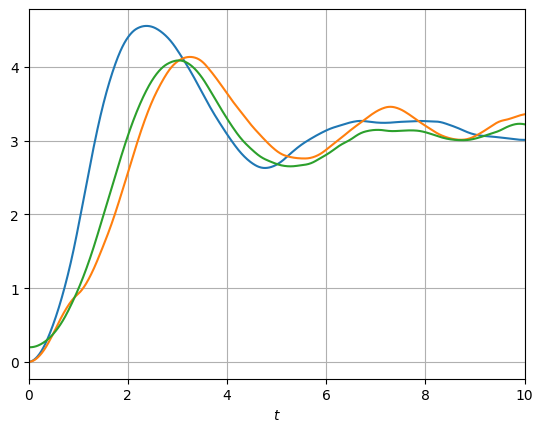

In [16]:
sns.lineplot(y = drone_trajectory[:, 0], x = timesteps).set(xlim=(timesteps[0], timesteps[-1]), xlabel='$t$')
sns.lineplot(y = drone_trajectory[:, 1], x = timesteps)
sns.lineplot(y = drone_trajectory[:, 2], x = timesteps)
plt.grid()

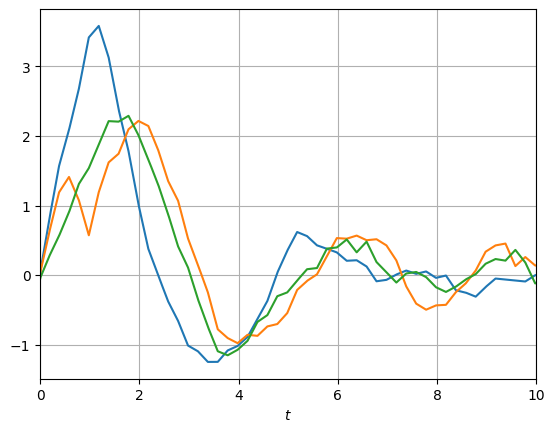

In [17]:
sns.lineplot(y = drone_velocity[:, 0], x = timesteps).set(xlim=(timesteps[0], timesteps[-1]), xlabel='$t$')
sns.lineplot(y = drone_velocity[:, 1], x = timesteps)
sns.lineplot(y = drone_velocity[:, 2], x = timesteps)
plt.grid()

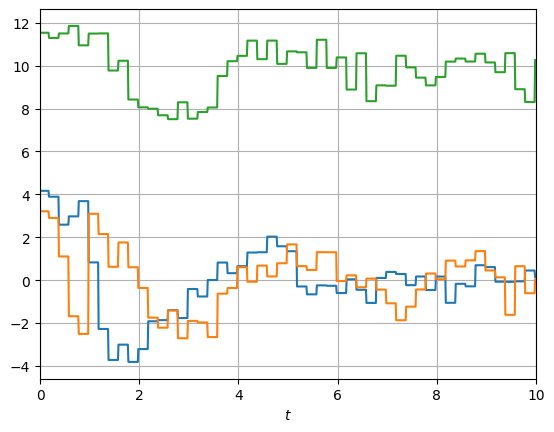

In [18]:
sns.lineplot(y = drone_thrust[:, 0], x = timesteps).set(xlim=(timesteps[0], timesteps[-1]), xlabel='$t$')
sns.lineplot(y = drone_thrust[:, 1], x = timesteps)
sns.lineplot(y = drone_thrust[:, 2], x = timesteps)
plt.grid()

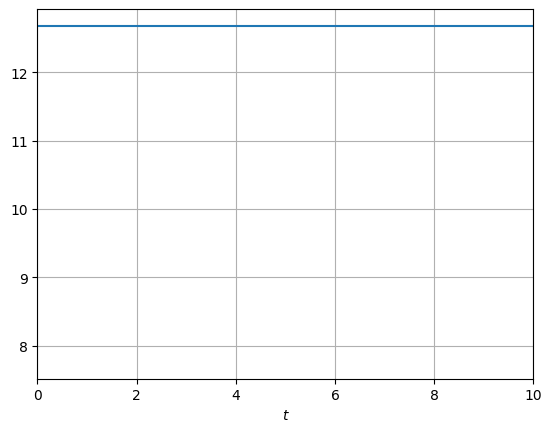

In [19]:
sns.lineplot(thrust_norm).set(xlim=(timesteps[0], timesteps[-1]), xlabel='$t$')
plt.grid()

## Simulation saving and visualization

We save the data of the simulation, and then use Manim to visualize it.

In [20]:
from src.simulation_data import DroneSimData
from src.manim_animator import DroneFlightScene
from manim import tempconfig

In [21]:
data = DroneSimData(
    trajectory=drone_trajectory, 
    velocity=drone_velocity, 
    goal_traj=goal_position, 
    timesteps=timesteps, 
    obstacles=np.asarray([[obs.x_lim[0], obs.x_lim[1], obs.y_lim[0], obs.y_lim[1]] for obs in obstacles])
)
data.to_npz('./data.npz')

In [22]:
# Simulation visualization render
DroneFlightScene.data_file = './data.npz'
scene = DroneFlightScene()

with tempconfig({"quality": "medium_quality", "preview": False, "disable_caching": False, "verbosity": "CRITICAL"}):
    scene = DroneFlightScene()
    scene.render()


<video src='./assets/trajectory.mp4' width=560 height=480 controls autoplay />



In the video above, we see the trajectory of the drone in blue. The green ball represents the goal and the pillars are the defined obstacles.  
We can see that our drone successfully evades the obstacles and arrives in the vicinity of the goal.

# Conclusion

In this notebook, we have demonstrated the simple avoidance scheme of potential fields and simulated a simple aerial drone.

# References

- Potential field path planning: https://www.cs.columbia.edu/~allen/F17/NOTES/potentialfield.pdf
- Manim: The Manim Community Developers. (2025). Manim – Mathematical Animation Framework (Version v0.19.0) [Computer software]. https://www.manim.community/